In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

import pymc3 as pm
import theano.tensor as tt
import scipy.stats as stats

from theano import shared
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize


tab10 = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD', 
         '#8C564B', '#CFECF9', '#7F7F7F', '#BCBD22', '#17BECF']

%matplotlib inline

In [2]:
df = pd.read_csv('full_data.csv')
df.head(n=3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2/25/20,Afghanistan,NaN,NaN,1,NaN
1,2/26/20,Afghanistan,0.0,NaN,1,NaN
2,2/27/20,Afghanistan,0.0,NaN,1,NaN


In [3]:
df.location.unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus',
       'Belgium', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil',
       'Brunei', 'Bulgaria', 'Burkina Faso', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Chile', 'China', 'Colombia',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czech Republic',
       "Cote d'Ivoire", 'Democratic Republic of Congo', 'Denmark',
       'Dominican Republic', 'Ecuador', 'Egypt', 'Estonia', 'Ethiopia',
       'Faeroe Islands', 'Finland', 'France', 'French Guiana',
       'French Polynesia', 'Gabon', 'Georgia', 'Germany', 'Ghana',
       'Gibraltar', 'Greece', 'Guadeloupe', 'Guernsey', 'Guinea',
       'Guyana', 'Vatican', 'Honduras', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'International', 'Iran', 'Iraq', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Jersey', 'Jordan

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2408 entries, 0 to 2407
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          2408 non-null   object 
 1   location      2408 non-null   object 
 2   new_cases     2272 non-null   float64
 3   new_deaths    418 non-null    float64
 4   total_cases   2408 non-null   int64  
 5   total_deaths  455 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 113.0+ KB


In [5]:
df.date = pd.to_datetime(df.date)

In [6]:
df = df.fillna(0)
df.head(n=3)

,date,location,new_cases,new_deaths,total_cases,total_deaths
0,2020-02-25,Afghanistan,0.0,0.0,1,0.0
1,2020-02-26,Afghanistan,0.0,0.0,1,0.0
2,2020-02-27,Afghanistan,0.0,0.0,1,0.0


In [7]:
italy = df[(df.location=='Italy') & (df.total_cases >= 100)].total_cases.to_list()
southkorea = df[(df.location=='South Korea') & (df.total_cases >= 100)].total_cases.to_list()
iran = df[(df.location=='Iran') & (df.total_cases >= 100)].total_cases.to_list()
germany = df[(df.location=='Germany') & (df.total_cases >= 100)].total_cases.to_list()
switzerland = df[(df.location=='Switzerland') & (df.total_cases >= 100)].total_cases.to_list()
usa = df[(df.location=='United States') & (df.total_cases >= 100)].total_cases.to_list()
philippines = df[(df.location=='Philippines') & (df.total_cases >= 100)].total_cases.to_list()
china = df[(df.location=='China') & (df.total_cases >= 100)].total_cases.to_list()

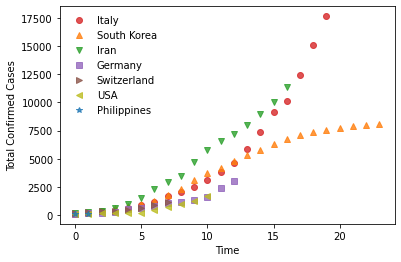

In [8]:
plt.plot(italy, 'o',
         color=tab10[3], alpha = 0.8, label='Italy');
plt.plot(southkorea, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');
plt.plot(iran, 'v', 
         color=tab10[2], alpha = 0.8, label='Iran');
plt.plot(germany, 's',   
         color=tab10[4], alpha = 0.8, label='Germany');
plt.plot(switzerland, '>', 
         color=tab10[5], alpha = 0.8, label='Switzerland');
plt.plot(usa, '<', 
         color=tab10[8], alpha = 0.8, label='USA');
plt.plot(philippines, '*',
         color=tab10[0], alpha = 0.8, label='Philippines');


plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

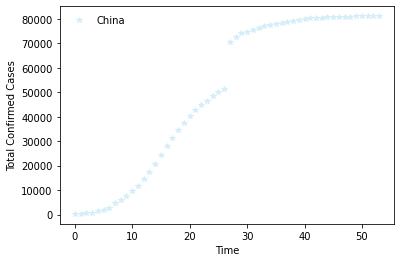

In [9]:
plt.plot(china, '*',
         color=tab10[6], alpha = 0.8, label='China');

plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

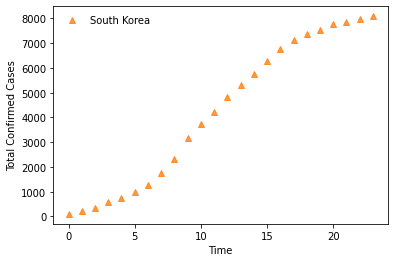

In [10]:
plt.plot(southkorea, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');

plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');

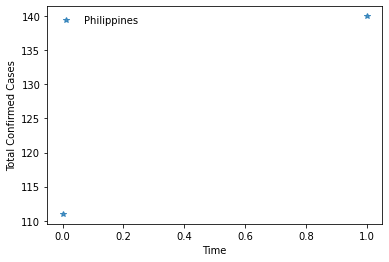

In [11]:
plt.plot(philippines, '*',
         color=tab10[0], alpha = 0.8, label='Philippines');
plt.legend(frameon=False);
plt.xlabel('Time');
plt.ylabel('Total Confirmed Cases');


In [12]:
##### Student T
y_southkorea = southkorea[-30:]

Y = np.array(y_southkorea)
X = np.arange(0, len(y_southkorea))

N_SAMPLES = 2000
LARGE_NUMBER = 1e5
    
with pm.Model() as covid_sokor_model:
    𝛼 = 10 * pm.Uniform("a", lower=0,upper=1)
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sigma=sigma, shape=Y.shape)
    #ymax / (1 + np.exp(-k*(x-x_0)))
    infection = pm.Deterministic('infection', np.exp(-𝛼*s)**0.5)

    covid_observed = pm.StudentT('covid_observed', nu=nu, sigma=infection, observed=Y)


In [13]:
#covid_sokor_model.check_test_point()

In [14]:
def infer_infection():
    with covid_sokor_model:
        res = pm.find_MAP(vars=[infection], method="L-BFGS-B")
        return res['infection']

In [15]:
with covid_sokor_model:
    covid_probability_trace = pm.sample(draws=10000, tune=200, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [s, sigma, nu, a]
Sampling 2 chains, 146 divergences: 100%|██████████| 20400/20400 [02:19<00:00, 145.75draws/s]
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 53 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12404ae80>,
      dtype=object)

<Figure size 504x504 with 0 Axes>

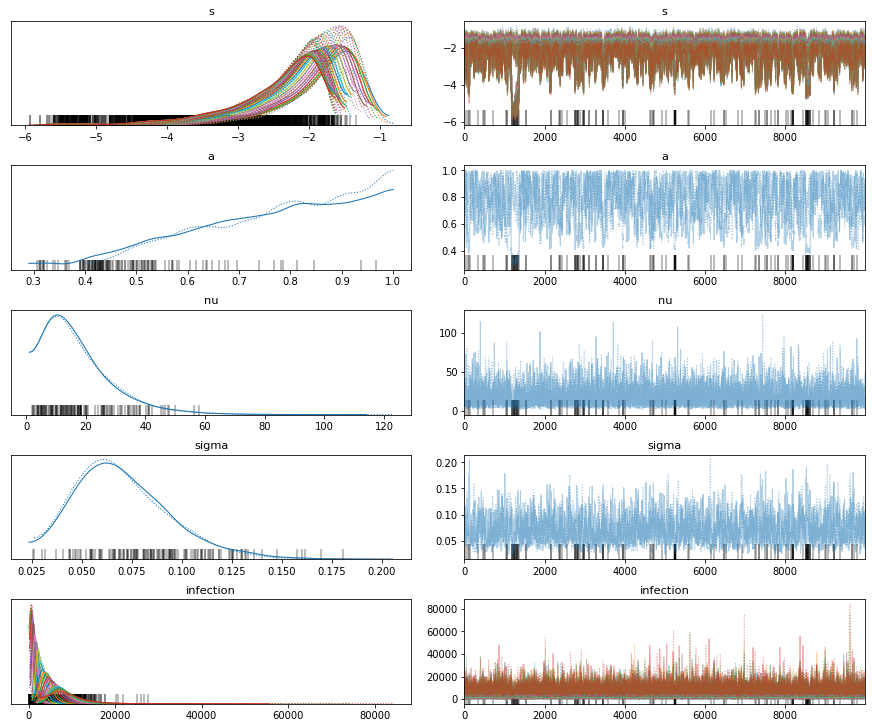

In [16]:
plt.figure(figsize=(7, 7))
pm.traceplot(covid_probability_trace)

Text(0, 0.5, 'Confirmed Cases in Suth Korea')

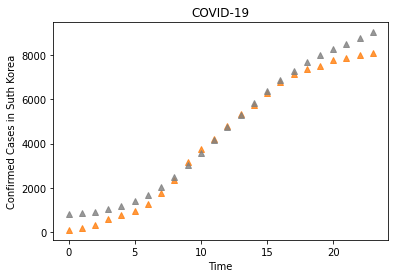

In [17]:

plt.plot(X, Y, '^', 
         color=tab10[1], alpha = 0.8, label='South Korea');

plt.plot(X, np.array(covid_probability_trace['infection'].mean(axis=0)), '^', 
         color=tab10[7], alpha = 0.8, label='Fitted' );
plt.title('COVID-19')
plt.xlabel('Time')
plt.ylabel('Confirmed Cases in Suth Korea')


In [18]:
ppc = pm.sample_posterior_predictive(covid_probability_trace, model=covid_sokor_model, samples=100)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 100/100 [00:00<00:00, 580.85it/s]


In [19]:
np.asarray(ppc['covid_observed']).shape


(100, 24)

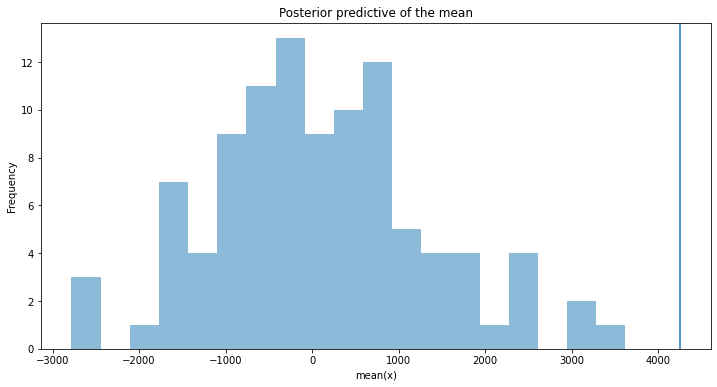

In [20]:

_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean() for n in ppc['covid_observed']], bins=19, alpha=0.5)
ax.axvline(Y.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');